In [11]:
# Import necessary packages

from IPython import display
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, BatchSampler
import torchvision
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pad_sequence

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import time
import datetime

import lightgbm as lgb
import xgboost as xgb

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GridSearchCV, StratifiedGroupKFold, cross_val_score, GroupKFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import ndcg_score as nd
from sklearn.datasets import load_svmlight_file
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import optuna

import pytorchltr
from pytorchltr.loss import LambdaARPLoss1, LambdaARPLoss2, LambdaNDCGLoss1, LambdaNDCGLoss2, PairwiseDCGHingeLoss, PairwiseHingeLoss, PairwiseLogisticLoss
from pytorchltr.evaluation import ndcg

import operator
import statistics

import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import shap

# Preprocess data

Read pointwise data

In [12]:
pointwise_data = pd.read_excel('processed_data.xlsx') # the dataset is mostly retrieved manually by Python packages

Drop rows with null values

In [13]:
pointwise_data = pointwise_data[pointwise_data.keyword != 'hastings property for sale']
pointwise_data = pointwise_data[pointwise_data.keyword != 'property for rent hertfordshire']
pointwise_data = pointwise_data[pointwise_data.keyword != 'property for sale bexhill']
pointwise_data = pointwise_data[pointwise_data.keyword != 'property for sale ceredigion']

Data normalization

In [14]:
# Extract data columns to select the columns to normalize
pointwise_data.columns

Index(['query_date', 'keyword', 'gg_srp', 'result_type', 'srp_title',
       'LP_link', 'domain_name', 'rank', 'srp_title_length',
       'keyword_in_srp_title', 'any_kw_in_srp_title', 'domain_age',
       'LP_pagesize', 'total_links', 'internal_links', 'external_links',
       'meta_tag', 'is_secure', 'content_download_time', 'response_time',
       'content_size', 'html_size', 'overall_score', 'speed_index',
       'first_meaningful_paint_index', 'first_contentful_paint_index',
       'time_to_interactive_index', 'total_blocking_time_index',
       'largest_contentful_paint_index', 'first_input_delay_index',
       'cumulative_layout_shift_index', 'uses_long_cache_ttl_index',
       'unused_javascript_index', 'speed', 'time_to_interactive',
       'total_byte_weight', 'largest_contentful_paint', 'first_input_delay',
       'cumulative_layout_shift', 'first_meaningful_paint',
       'first_contentful_paint', 'total_blocking_time', 'server_response_time',
       'numTasks', 'maxRtt', '

In [15]:
# Scale the suitable columns
scaler = StandardScaler() #Initialize z-score normalization
columns_to_normalize = ['srp_title_length',
       'keyword_in_srp_title', 'any_kw_in_srp_title', 'domain_age',
       'LP_pagesize', 'total_links', 'internal_links', 'external_links',
       'meta_tag', 'is_secure', 'content_download_time', 'response_time',
       'content_size', 'html_size', 'overall_score', 'speed_index',
       'first_meaningful_paint_index', 'first_contentful_paint_index',
       'time_to_interactive_index', 'total_blocking_time_index',
       'largest_contentful_paint_index', 'first_input_delay_index',
       'cumulative_layout_shift_index', 'uses_long_cache_ttl_index',
       'unused_javascript_index', 'speed', 'time_to_interactive',
       'total_byte_weight', 'largest_contentful_paint', 'first_input_delay',
       'cumulative_layout_shift', 'first_meaningful_paint',
       'first_contentful_paint', 'total_blocking_time', 'server_response_time',
       'numTasks', 'maxRtt', 'mainDocumentTransferSize', 'numScripts',
       'totalTaskTime', 'numTasksOver500ms', 'numTasksOver100ms',
       'numTasksOver50ms', 'numTasksOver25ms', 'numTasksOver10ms',
       'numRequests', 'numStylesheets', 'uses_long_cache_ttl',
       'unused_javascript', 'amount_of_text', 'total_heading',
       'total_heading_length', 'keyword_in_total_heading', 'heading1',
       'heading1_length', 'keyword_in_heading1', 'heading2', 'heading2_length',
       'keyword_in_heading2', 'heading3', 'heading3_length',
       'keyword_in_heading3', 'total_img', 'keyword_in_img_alt',
       'keyword_in_anchor', 'any_kw_in_anchor', 'keyword_in_footer',
       'any_kw_in_footer', 'keyword_in_url', 'any_kw_in_url',
       'keyword_in_body', 'meta_length', 'keyword_in_meta',
       'is_title_tag_used', 'domain_pagerank', 'selfcalc_pagerank']
pointwise_data[columns_to_normalize] = scaler.fit_transform(pointwise_data[columns_to_normalize]) #Normalize

#Display the standardized data
pointwise_data

,query_date,keyword,gg_srp,result_type,srp_title,LP_link,domain_name,rank,srp_title_length,keyword_in_srp_title,...,keyword_in_footer,any_kw_in_footer,keyword_in_url,any_kw_in_url,keyword_in_body,meta_length,keyword_in_meta,is_title_tag_used,domain_pagerank,selfcalc_pagerank
0,20230503,1 bedroom house for rent,https://www.google.com/search?q=1%20bedroom%20...,Organic,1 Bedroom Houses To Rent in Greater London,https://www.rightmove.co.uk/property-to-rent/L...,https://www.rightmove.co.uk,1,0.260214,-0.219636,...,-0.036475,-0.370439,-0.032989,0.173155,-0.084735,0.276974,-0.147237,0.032989,1.012955,-0.008267
1,20230503,1 bedroom house for rent,https://www.google.com/search?q=1%20bedroom%20...,Organic,1 Bedroom houses to rent in London,https://www.zoopla.co.uk/to-rent/houses/1-bedr...,https://www.zoopla.co.uk,2,-0.509871,-0.219636,...,-0.036475,-0.370439,-0.032989,0.173155,-0.084735,0.025236,-0.147237,0.032989,0.768304,0.070154
2,20230503,1 bedroom house for rent,https://www.google.com/search?q=1%20bedroom%20...,Organic,1 Bedroom houses to rent in North London,https://www.zoopla.co.uk/to-rent/houses/1-bedr...,https://www.zoopla.co.uk,3,0.067693,-0.219636,...,-0.036475,-0.370439,-0.032989,0.173155,-0.084735,0.029841,-0.147237,0.032989,0.768304,-0.058558
3,20230503,1 bedroom house for rent,https://www.google.com/search?q=1%20bedroom%20...,Organic,Search 1+ Bed Houses To Rent In London,https://www.onthemarket.com/to-rent/1-bed-hous...,https://www.onthemarket.com,4,-0.124828,-0.219636,...,-0.036475,2.699498,-0.032989,0.173155,-0.084735,0.660976,-0.147237,0.032989,0.324308,-0.075753
4,20230503,1 bedroom house for rent,https://www.google.com/search?q=1%20bedroom%20...,Organic,1 Bedroom Flats and Houses to Rent in London,https://www.gumtree.com/flats-houses/property-...,https://www.gumtree.com,5,0.452735,-0.219636,...,-0.036475,-0.370439,-0.032989,0.173155,-0.084735,0.338885,-0.147237,0.032989,0.722998,-0.094151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8313,20230505,zoopla property value,https://www.google.com/search?q=zoopla%20prope...,Organic,House prices in London - sold prices and estim...,https://www.zoopla.co.uk/house-prices/london/,https://www.zoopla.co.uk,6,1.030299,-0.219636,...,-0.036475,-0.370439,-0.032989,0.173155,-0.084735,-0.064560,-0.147237,0.032989,0.768304,0.420911
8314,20230505,zoopla property value,https://www.google.com/search?q=zoopla%20prope...,Organic,"Zoopla > Search Property to Buy, Rent, House P...",https://www.zoopla.co.uk/,https://www.zoopla.co.uk,7,2.281686,-0.219636,...,-0.036475,-0.370439,-0.032989,0.173155,-0.084735,0.137802,-0.147237,0.032989,0.768304,8.426398
8315,20230505,zoopla property value,https://www.google.com/search?q=zoopla%20prope...,Organic,"House prices in South London, London",https://www.zoopla.co.uk/house-prices/south-lo...,https://www.zoopla.co.uk,8,-0.317349,-0.219636,...,-0.036475,-0.370439,-0.032989,0.173155,-0.084735,-0.060979,-0.147237,0.032989,0.768304,-0.046721
8316,20230505,zoopla property value,https://www.google.com/search?q=zoopla%20prope...,Organic,House prices in Street - sold prices and estim...,https://www.zoopla.co.uk/house-prices/street/,https://www.zoopla.co.uk,9,1.030299,-0.219636,...,-0.036475,-0.370439,-0.032989,0.173155,-0.084735,-0.412491,-0.147237,0.032989,0.768304,-0.058509


# Model Selection

## Pointwise Learning-To-Rank Model
- Loss function = MSELoss
- Using XGBoost Model for ranking task
- Evaluation metric: NDCG

Neural Net

In [6]:
class MyDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        feature = self.features[index]
        target = self.targets[index]
        return feature, target
    
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 256)
        self.fc3 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

def init_weights(m):
    if type(m) == nn.Linear: # by checking the type we can init different layers in different ways
        torch.nn.init.kaiming_normal_(m.weight)

def data(data, columns_to_normalize):
    grouped_data = data.groupby('keyword')
    query_features = []  # List to store query features
    query_urls = []  # List to store URLs for each query
    query_ranks = []  # List to store ranks for each URL

    for query, group in grouped_data:
        urls = group['LP_link'].tolist()  # Get URLs for the query
        ranks = group['rank'].tolist()  # Get ranks for the URLs
        features = group[columns_to_normalize].values.tolist()  # Get features for the URLs

        query_urls.extend(urls)
        query_ranks.extend(ranks)
        query_features.extend(features)
       
    input_data = torch.tensor(query_features, dtype=torch.float32)
    target_data = torch.tensor(query_ranks, dtype=torch.long)
    
    return input_data, target_data

def train_ltr(net, train_iter, test_iter, traingroup, testgroup, loss, num_epochs, optimizer):
    if isinstance(net, torch.nn.Module):
        net.train()
        
    loss_ = []
    train_ndcg = []
    test_ndcg = []
    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0
        total_ndcg = 0
        total_test_ndcg = 0
        test_batches = 0
        out_train = torch.tensor([])
        out_test = torch.tensor([])
        rank_train = torch.tensor([])
        rank_test = torch.tensor([])
        for i, v in train_dataloader:
            optimizer.zero_grad()
            output = model(i)
            out_train = torch.cat((out_train, output), dim=0)
            rank_train = torch.cat((rank_train, v), dim=0)
            v=v.float().view(-1,1)
            loss = l(output, v)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1
        
        out_train = torch.split(out_train, train_groups)
        rank_train = torch.split(rank_train, train_groups)
        for t1, t2 in zip(out_train, rank_train):
            if len(t1)==1:
                pass
            else:
                ndcg_score = nd(np.asarray([t2.tolist()]), np.asarray([t1.view(-1).tolist()])).mean()
            total_ndcg += ndcg_score

        for a, b in test_dataloader:
            test_output = model(a)
            out_test = torch.cat((out_test, test_output), dim=0)
            rank_test = torch.cat((rank_test, b), dim=0)
            test_batches += 1
            
        out_test = torch.split(out_test, test_groups)
        rank_test = torch.split(rank_test, test_groups)
        for t3, t4 in zip(out_test, rank_test):
            if len(t3)==1:
                pass
            else:
                test_ndcg_score = nd(np.asarray([t4.tolist()]), np.asarray([t3.view(-1).tolist()])).mean()
            total_test_ndcg += test_ndcg_score

        average_loss = total_loss/num_batches
        average_ndcg = total_ndcg/len(train_groups)
        average_test_ndcg = total_test_ndcg/len(test_groups)
        
        loss_.append(average_loss)
        train_ndcg.append(average_ndcg)
        test_ndcg.append(average_test_ndcg)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}, Train-NDCG: {average_ndcg}, Test-NDCG: {average_test_ndcg}")
    return loss_, train_ndcg, test_ndcg

In [7]:
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state = 1).split(pointwise_data, groups=pointwise_data['keyword'])
X_train_inds, X_test_inds = next(gss)
train_data= pointwise_data.iloc[X_train_inds]
test_data= pointwise_data.iloc[X_test_inds]

train_groups = list(train_data.groupby('keyword').size().to_numpy())
test_groups = list(test_data.groupby('keyword').size().to_numpy())

train_input, train_target = torch.tensor(train_data[columns_to_normalize].values), torch.tensor(train_data['rank'].values)
test_input, test_target = torch.tensor(test_data[columns_to_normalize].values), torch.tensor(test_data['rank'].values)

train_dataset = MyDataset(train_input.float(), train_target.float())
train_dataloader = DataLoader(train_dataset, batch_size=16)

test_dataset = MyDataset(test_input.float(), test_target.float())
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Initialize the ListNet model
input_dim = train_input.size()[1]
hidden_dim = 512  # Define the desired number of hidden units
output_dim = 1  # Assuming you are predicting a single value per query

# Initialize the ListNet model
model = Net(input_dim, hidden_dim, output_dim)
model.apply(init_weights)

#Loss function
l = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

#Train model
start_time = time.time()
loss, train_ndcg, test_ndcg = train_ltr(model, train_dataloader, test_dataloader, train_groups, test_groups, l, 100, optimizer)
end_time = time.time()
train_elapsed_time = end_time - start_time

Epoch 1/100, Loss: 6.517211297333959, Train-NDCG: 0.9167118128266534, Test-NDCG: 0.9237980359817782
Epoch 2/100, Loss: 4.558245694350047, Train-NDCG: 0.9267956009728348, Test-NDCG: 0.9259689563570651
Epoch 3/100, Loss: 4.0537046050450884, Train-NDCG: 0.9344721019311563, Test-NDCG: 0.9215852543785843
Epoch 4/100, Loss: 3.7511012396180488, Train-NDCG: 0.9394234032469306, Test-NDCG: 0.9266529318046307
Epoch 5/100, Loss: 3.630544313321631, Train-NDCG: 0.9443224149437746, Test-NDCG: 0.9257716128433187
Epoch 6/100, Loss: 3.3998104757573233, Train-NDCG: 0.9463847322211588, Test-NDCG: 0.9228777769263976
Epoch 7/100, Loss: 3.292119526863098, Train-NDCG: 0.9497396136467007, Test-NDCG: 0.9304629323507364
Epoch 8/100, Loss: 3.202661083118025, Train-NDCG: 0.9513691716805365, Test-NDCG: 0.9251857514882421
Epoch 9/100, Loss: 3.1255168259861956, Train-NDCG: 0.953436256444613, Test-NDCG: 0.9292734151515334
Epoch 10/100, Loss: 3.044739326511521, Train-NDCG: 0.9546988762139972, Test-NDCG: 0.9282376003320

Epoch 82/100, Loss: 1.6363763219979872, Train-NDCG: 0.9794314424872055, Test-NDCG: 0.9244918211421111
Epoch 83/100, Loss: 1.6552705666746002, Train-NDCG: 0.9800420544521078, Test-NDCG: 0.9273692286485501
Epoch 84/100, Loss: 1.6328671694879073, Train-NDCG: 0.9800202844185997, Test-NDCG: 0.927677681434506
Epoch 85/100, Loss: 1.5830255981310304, Train-NDCG: 0.9797747992048926, Test-NDCG: 0.9306742397611271
Epoch 86/100, Loss: 1.6066637766289424, Train-NDCG: 0.9800101850938223, Test-NDCG: 0.9267501161437293
Epoch 87/100, Loss: 1.5859154999974263, Train-NDCG: 0.9806407782402402, Test-NDCG: 0.9263472086423189
Epoch 88/100, Loss: 1.5700958858053369, Train-NDCG: 0.9801447717614113, Test-NDCG: 0.9283394219040769
Epoch 89/100, Loss: 1.5778696982257336, Train-NDCG: 0.9800972578757933, Test-NDCG: 0.9265463304119467
Epoch 90/100, Loss: 1.5831201869321156, Train-NDCG: 0.9800698039618587, Test-NDCG: 0.9307260677441134
Epoch 91/100, Loss: 1.6025049802409597, Train-NDCG: 0.9797461353085599, Test-NDCG: 

In [8]:
#Total training time
print('Total training time: ', train_elapsed_time)

Total training time:  116.80758237838745


In [9]:
scores1 = []
out_test = torch.tensor([])
rank_test = torch.tensor([])
start_time = time.time()
for a, b in test_dataloader:
    test_output = model(a)
    out_test = torch.cat((out_test, test_output), dim=0)
    rank_test = torch.cat((rank_test, b), dim=0)
            
out_test = torch.split(out_test, test_groups)
rank_test = torch.split(rank_test, test_groups)
for t3, t4 in zip(out_test, rank_test):
    if len(t3)==1:
        pass
    else:
        scores1.append(nd(np.asarray([t4.tolist()]), np.asarray([t3.view(-1).tolist()])))
end_time = time.time()
test_elapsed_time = end_time - start_time

#Total test time
print('Total test time: ', test_elapsed_time)
print(np.mean(scores1), np.median(scores1), max(scores1), min(scores1))

Total test time:  0.09854292869567871
0.9298965742322632 0.9389642938835822 1.0 0.7194030537056085


## Pairwise Learning-To-Rank Model
- For RankNet: Loss function = Pairwise Loss (similar to negative log likelihood loss of relative ranking/preferences)
    - Use Neural Net model
- For LambdaRank or LambdaMart (boosted tree version of LambdaRank): Directly using gradient for Gradient Descent optimization, to improve evaluation metric
    - Using XGBoost Model
- Evaluation Metric: NDCG

Intuition: comparing a pair of datapoints is usually easier to evaluate a single one

### RankNet

In [6]:
# Set up GPU resource
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_grad_enabled(True) # Enable GPU
torch.cuda.empty_cache() # Clear cuda cache (if any)

class MyDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        feature = self.features[index]
        target = self.targets[index]
        return feature, target
    
class RankNet(nn.Module):
    def __init__(self, num_feature):
        super(RankNet, self).__init__()

        self.model = nn.Sequential(
            nn.Linear( num_feature, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        self.output_sig = nn.Sigmoid()

    def forward(self, input_1,input_2):
        s1 = self.model(input_1)
        s2 = self.model(input_2)
        out = self.output_sig(s1-s2)
        return out
    
    def predict(self, input_):
        s = self.model(input_)
        return s
    
def init_weights(m):
    if type(m) == nn.Linear: # by checking the type we can init different layers in different ways
        torch.nn.init.kaiming_normal_(m.weight)
        
def pairwise_format(data, columns_to_normalize):
    grouped_data = data.groupby('keyword')
    query_features1 = []  # List to store query features
    query_features2 = []
    query_urls = []  # List to store URLs for each query
    query_ranks = []  # List to store ranks for each URL

    for query, group in grouped_data:
        if len(group['rank'].tolist()) == 10:
            urls = group['LP_link'].tolist()  # Get URLs for the query
            ranks = group['rank'].tolist()  # Get ranks for the URLs
            features = group[columns_to_normalize].values.tolist()  # Get features for the URLs

            num_urls = len(urls)
            r = []
            url = []
            f1 = []
            f2 = []
            for i in range(num_urls):
                for j in range(num_urls):
                    if ranks[i] == ranks[j]:
                        pass
                    else:
                        url.append((urls[i], urls[j]))
                        query_urls.append(url)
                        r.append(1 if ranks[i] < ranks[j] else 0)
                        query_ranks.append(r)
                        f1.append(list(features[i]))
                        query_features1.append(f1)
                        f2.append(list(features[j]))
                        query_features2.append(f2)
        else:
            pass 
    
    input1, input2 = torch.tensor(query_features1, dtype=torch.float32), torch.tensor(query_features2, dtype=torch.float32)
    target_data = torch.tensor(query_ranks, dtype=torch.long)
    
    return input1, input2, target_data

def val_format(data, columns_to_normalize):
    grouped_data = data.groupby('keyword')
    query_features = []  # List to store query features
    query_urls = []  # List to store URLs for each query
    query_ranks = []  # List to store ranks for each URL

    for query, group in grouped_data:
        if len(group['rank'].tolist()) == 10:
            urls = group['LP_link'].tolist()  # Get URLs for the query
            ranks = group['rank'].tolist()  # Get ranks for the URLs
            features = group[columns_to_normalize].values.tolist()  # Get features for the URLs

            query_urls.append(urls)
            query_ranks.append(ranks)
            query_features.append(features)
        else:
            pass 
    
    input_data = torch.tensor(query_features, dtype=torch.float32)
    target_data = torch.tensor(query_ranks, dtype=torch.long)
    
    return input_data, target_data

def train_ltr(net, train_iter1, train_iter2, train_iter_check, test_iter_check, loss, num_epochs, optimizer):
    if isinstance(net, torch.nn.Module):
        net.train()
        
    loss_ = []
    train_ndcg = []
    test_ndcg = []
    train_acc = []
    test_acc = []
    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0
        total_ndcg = []
        total_test_ndcg = []
        
        for (i1, v1), (i2, v2) in zip(train_iter1, train_iter2):
            i1, i2, v1 = i1.to(device), i2.to(device), v1.to(device)
            optimizer.zero_grad()
            output = net(i1, i2)
            v1 = v1.float()
            loss = l(output.view(-1,90), v1)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1
            
        for t1, t2 in train_check_loader:
            t1, t2 = t1.to(device), t2.to(device)
            train_output = net.predict(t1)
            
            for t3, t4 in zip(train_output, t2):
                ndcg_score = nd(np.asarray([t4.flatten().tolist()]), np.asarray([t3.flatten().tolist()]))
                total_ndcg.append(ndcg_score)
            
        for a, b in test_check_loader:
            a, b = a.to(device), b.to(device)
            test_output = net.predict(a)
            
            for a1, b1 in zip(test_output, b):
                test_ndcg_score = nd(np.asarray([b1.flatten().tolist()]), np.asarray([a1.flatten().tolist()]))
                total_test_ndcg.append(test_ndcg_score)
            
        average_loss = total_loss/num_batches
        average_ndcg = np.mean(total_ndcg)
        average_test_ndcg = np.mean(total_test_ndcg)
        
        loss_.append(average_loss)
        train_ndcg.append(average_ndcg)
        test_ndcg.append(average_test_ndcg)
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}, Train-NDCG: {average_ndcg}, Test-NDCG: {average_test_ndcg}")
#         print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")
    return loss_, train_ndcg, test_ndcg

In [7]:
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state = 1).split(pointwise_data, groups=pointwise_data['keyword'])
X_train_inds, X_test_inds = next(gss)
train_data= pointwise_data.iloc[X_train_inds]
test_data= pointwise_data.iloc[X_test_inds] 

#Re-format to train pairwise
train_input1, train_input2, train_target = pairwise_format(train_data, columns_to_normalize)
test_input1, test_input2, test_target = pairwise_format(test_data, columns_to_normalize)

#Format to check model perf on train and val set
train_input_check, train_target_check = val_format(train_data, columns_to_normalize)
test_input_check, test_target_check = val_format(test_data, columns_to_normalize)

# Used to train model
train_dataset1 = MyDataset(train_input1, train_target)
train_dataset2 = MyDataset(train_input2, train_target)
train_dataloader1 = DataLoader(train_dataset1, batch_size=16, shuffle=True)
train_dataloader2 = DataLoader(train_dataset2, batch_size=16, shuffle=True)

# Used to validate NDCG
train_dataset = MyDataset(train_input_check, train_target_check)
test_dataset = MyDataset(test_input_check, test_target_check)
train_check_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_check_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

#Initialize model
model = RankNet(num_feature=76).to(device)

#Loss function
l = nn.BCELoss().to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

#Train model
loss, train_ndcg, test_ndcg = train_ltr(model, train_dataloader1, train_dataloader2, train_check_loader, test_check_loader, l, 20, optimizer)

Epoch 1/20, Loss: 0.29300768890859713, Train-NDCG: 0.6792987092250953, Test-NDCG: 0.697161128260362
Epoch 2/20, Loss: 0.22727355220060594, Train-NDCG: 0.6780645880196917, Test-NDCG: 0.6964781921198754
Epoch 3/20, Loss: 0.20296626540217494, Train-NDCG: 0.6763797306942089, Test-NDCG: 0.6991798713078782
Epoch 4/20, Loss: 0.18961972724143894, Train-NDCG: 0.6755141956924252, Test-NDCG: 0.7009367604357417
Epoch 5/20, Loss: 0.1803699584849128, Train-NDCG: 0.6754479237309704, Test-NDCG: 0.7001853269364128
Epoch 6/20, Loss: 0.17333314158833565, Train-NDCG: 0.6749036609161024, Test-NDCG: 0.6995788465934286
Epoch 7/20, Loss: 0.16731398967196115, Train-NDCG: 0.674718988858718, Test-NDCG: 0.6986866303752604
Epoch 8/20, Loss: 0.16370810547750958, Train-NDCG: 0.6754140367679744, Test-NDCG: 0.7002323382477565
Epoch 9/20, Loss: 0.1604418269720874, Train-NDCG: 0.674720481915337, Test-NDCG: 0.6970249666123012
Epoch 10/20, Loss: 0.15644849847722525, Train-NDCG: 0.6740625991453144, Test-NDCG: 0.70037236431

In [8]:
score2 = []
for a, b in test_check_loader:
    a, b = a.to(device), b.to(device)
    test_output = model.predict(a)
            
    for a1, b1 in zip(test_output, b):
        test_ndcg_score = nd(np.asarray([b1.flatten().tolist()]), np.asarray([a1.flatten().tolist()]))
        score2.append(test_ndcg_score)

In [9]:
np.mean(score2), np.median(score2), max(score2), min(score2)

(0.7019535001230999,
 0.6891418386037687,
 0.8798842987833513,
 0.6703287849639836)

### LambdaRank

In [56]:
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state = 1).split(pointwise_data, groups=pointwise_data['keyword'])
X_train_inds, X_test_inds = next(gss)
train_data= pointwise_data.iloc[X_train_inds]
test_data= pointwise_data.iloc[X_test_inds]

# Split the data into input features (X) and target labels (y)
X_train = train_data[columns_to_normalize]
y_train = train_data['rank']

X_test = test_data[columns_to_normalize]
y_test = test_data['rank']

train_groups = train_data.groupby('keyword').size().to_frame('size')['size'].to_numpy()
test_groups = test_data.groupby('keyword').size().to_frame('size')['size'].to_numpy()

# Create DMatrix for training set
dtrain = xgb.DMatrix(X_train, label=y_train)
dtrain.set_group(train_groups)

# Create DMatrix for test set
dtest = xgb.DMatrix(X_test, label=y_test)
dtest.set_group(test_groups)

params = {
    'objective': 'lambdarank',
#     'boosting_type': "gbdt",
#     'booster': 'gbtree',
#     'eval_metric': ['logloss', 'ndcg'],
    'metric': ['ndcg'],
    'random_state': 21,
    'lambdarank_num_pair_per_sample': 80,
    'lambdarank_pair_method': 'mean',
    'reg_lambda': 1
}
# Train the model
lgb_train = lgb.Dataset(X_train, y_train, group=train_groups)
lgb_test = lgb.Dataset(X_test, y_test, group=test_groups)
start_time = time.time()
ranker = lgb.train(params, lgb_train, num_boost_round=500, valid_sets=[lgb_train, lgb_test])
end_time = time.time()
train_elapsed_time = end_time - start_time

[LightGBM] [Warning] Unknown parameter: lambdarank_num_pair_per_sample
[LightGBM] [Warning] Unknown parameter: lambdarank_pair_method
[LightGBM] [Warning] Unknown parameter: lambdarank_num_pair_per_sample
[LightGBM] [Warning] Unknown parameter: lambdarank_pair_method
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10222
[LightGBM] [Info] Number of data points in the train set: 6635, number of used features: 71
[LightGBM] [Warning] Unknown parameter: lambdarank_num_pair_per_sample
[LightGBM] [Warning] Unknown parameter: lambdarank_pair_method
[1]	training's ndcg@1: 0.175689	training's ndcg@2: 0.285588	training's ndcg@3: 0.409777	training's ndcg@4: 0.500192	training's ndcg@5: 0.57311	valid_1's ndcg@1: 0.171982	valid_1's ndcg@2: 0.293576	valid_1's ndcg@3: 0.424757	valid_1's ndcg@4: 0.509939	valid_1's ndcg@5: 0.566962
[2]	training's ndcg@1: 0.544

[158]	training's ndcg@1: 0.983943	training's ndcg@2: 0.977423	training's ndcg@3: 0.972198	training's ndcg@4: 0.971412	training's ndcg@5: 0.974569	valid_1's ndcg@1: 0.592478	valid_1's ndcg@2: 0.639997	valid_1's ndcg@3: 0.692542	valid_1's ndcg@4: 0.737602	valid_1's ndcg@5: 0.775997
[159]	training's ndcg@1: 0.983943	training's ndcg@2: 0.978106	training's ndcg@3: 0.972404	training's ndcg@4: 0.971573	training's ndcg@5: 0.975102	valid_1's ndcg@1: 0.591948	valid_1's ndcg@2: 0.634846	valid_1's ndcg@3: 0.688558	valid_1's ndcg@4: 0.736392	valid_1's ndcg@5: 0.774485
[160]	training's ndcg@1: 0.983943	training's ndcg@2: 0.97828	training's ndcg@3: 0.973062	training's ndcg@4: 0.97174	training's ndcg@5: 0.975345	valid_1's ndcg@1: 0.58912	valid_1's ndcg@2: 0.637391	valid_1's ndcg@3: 0.689524	valid_1's ndcg@4: 0.736522	valid_1's ndcg@5: 0.775041
[161]	training's ndcg@1: 0.983943	training's ndcg@2: 0.97845	training's ndcg@3: 0.97332	training's ndcg@4: 0.971968	training's ndcg@5: 0.975428	valid_1's ndcg@1

[308]	training's ndcg@1: 1	training's ndcg@2: 0.996971	training's ndcg@3: 0.992082	training's ndcg@4: 0.989056	training's ndcg@5: 0.989992	valid_1's ndcg@1: 0.593034	valid_1's ndcg@2: 0.639021	valid_1's ndcg@3: 0.687652	valid_1's ndcg@4: 0.746656	valid_1's ndcg@5: 0.77314
[309]	training's ndcg@1: 1	training's ndcg@2: 0.996971	training's ndcg@3: 0.992082	training's ndcg@4: 0.989094	training's ndcg@5: 0.990041	valid_1's ndcg@1: 0.590029	valid_1's ndcg@2: 0.635634	valid_1's ndcg@3: 0.685414	valid_1's ndcg@4: 0.745138	valid_1's ndcg@5: 0.772927
[310]	training's ndcg@1: 1	training's ndcg@2: 0.996971	training's ndcg@3: 0.992082	training's ndcg@4: 0.989114	training's ndcg@5: 0.9902	valid_1's ndcg@1: 0.588793	valid_1's ndcg@2: 0.635415	valid_1's ndcg@3: 0.685122	valid_1's ndcg@4: 0.746131	valid_1's ndcg@5: 0.773047
[311]	training's ndcg@1: 1	training's ndcg@2: 0.996971	training's ndcg@3: 0.992082	training's ndcg@4: 0.989149	training's ndcg@5: 0.990215	valid_1's ndcg@1: 0.588793	valid_1's ndcg@

[465]	training's ndcg@1: 1	training's ndcg@2: 0.99951	training's ndcg@3: 0.996194	training's ndcg@4: 0.993756	training's ndcg@5: 0.993856	valid_1's ndcg@1: 0.604523	valid_1's ndcg@2: 0.644758	valid_1's ndcg@3: 0.69408	valid_1's ndcg@4: 0.745191	valid_1's ndcg@5: 0.772071
[466]	training's ndcg@1: 1	training's ndcg@2: 0.99951	training's ndcg@3: 0.996194	training's ndcg@4: 0.993788	training's ndcg@5: 0.993859	valid_1's ndcg@1: 0.604523	valid_1's ndcg@2: 0.645115	valid_1's ndcg@3: 0.693902	valid_1's ndcg@4: 0.745224	valid_1's ndcg@5: 0.772103
[467]	training's ndcg@1: 1	training's ndcg@2: 0.99951	training's ndcg@3: 0.996194	training's ndcg@4: 0.993795	training's ndcg@5: 0.993854	valid_1's ndcg@1: 0.604523	valid_1's ndcg@2: 0.645114	valid_1's ndcg@3: 0.693902	valid_1's ndcg@4: 0.744867	valid_1's ndcg@5: 0.772315
[468]	training's ndcg@1: 1	training's ndcg@2: 0.99951	training's ndcg@3: 0.996195	training's ndcg@4: 0.99382	training's ndcg@5: 0.993931	valid_1's ndcg@1: 0.604523	valid_1's ndcg@2: 

In [57]:
#Total training time
print('Total training time: ', train_elapsed_time)

Total training time:  0.7371127605438232


In [58]:
scores3 =[]
start_time = time.time()
for query, group in test_data.groupby('keyword'):
    if len(group['rank'].tolist()) != 1:
        urls = group['LP_link'].tolist()  # Get URLs for the query
        ranks = group['rank'].tolist()  # Get ranks for the URLs
        features = group[columns_to_normalize].values.tolist()  # Get features for the URLs
        scores3.append(nd(np.asarray([ranks]), np.asarray([ranker.predict(features).tolist()])))
end_time = time.time()
test_elapsed_time = end_time - start_time

#Total test time
print('Total test time: ', test_elapsed_time)
print(np.mean(scores3), np.median(scores3), max(scores3), min(scores3))

Total test time:  0.19068312644958496
0.9489042716602034 0.9640039097168491 1.0 0.7597656473809588


### LambdaMart

In [85]:
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state = 1).split(pointwise_data, groups=pointwise_data['keyword'])
X_train_inds, X_test_inds = next(gss)
train_data= pointwise_data.iloc[X_train_inds]
test_data= pointwise_data.iloc[X_test_inds]

# Split the data into input features (X) and target labels (y)
X_train = train_data[columns_to_normalize]
y_train = train_data['rank']

X_test = test_data[columns_to_normalize]
y_test = test_data['rank']

train_groups = train_data.groupby('keyword').size().to_numpy()
test_groups = test_data.groupby('keyword').size().to_numpy()

ranker = xgb.XGBRanker(tree_method='hist',
                        booster='gbtree',
                        objective='rank:ndcg',
                        eval_metric=['logloss', 'ndcg'],
                        random_state=21,  
                        n_estimators=500,
                        lambdarank_num_pair_per_sample=8,
                        lambdarank_pair_method='topk',
                        reg_lambda=1)
start_time = time.time()
ranker.fit(X_train, y_train, group=train_groups, verbose=True, eval_set=[(X_train, y_train),(X_test, y_test)], eval_group=[train_groups, test_groups])
end_time = time.time()
train_elapsed_time = end_time - start_time

[0]	validation_0-logloss:51.93183	validation_0-ndcg:0.69369	validation_1-logloss:54.20656	validation_1-ndcg:0.68434
[1]	validation_0-logloss:53.87344	validation_0-ndcg:0.82554	validation_1-logloss:57.65369	validation_1-ndcg:0.77212
[2]	validation_0-logloss:71.92207	validation_0-ndcg:0.85231	validation_1-logloss:78.06542	validation_1-ndcg:0.77918
[3]	validation_0-logloss:74.80555	validation_0-ndcg:0.87151	validation_1-logloss:81.77691	validation_1-ndcg:0.77419
[4]	validation_0-logloss:84.34927	validation_0-ndcg:0.88239	validation_1-logloss:94.31347	validation_1-ndcg:0.78215
[5]	validation_0-logloss:85.79665	validation_0-ndcg:0.89387	validation_1-logloss:94.00690	validation_1-ndcg:0.78109
[6]	validation_0-logloss:85.51331	validation_0-ndcg:0.90404	validation_1-logloss:94.09389	validation_1-ndcg:0.77669
[7]	validation_0-logloss:86.11435	validation_0-ndcg:0.90971	validation_1-logloss:94.59760	validation_1-ndcg:0.78705
[8]	validation_0-logloss:88.66688	validation_0-ndcg:0.91231	validation_1

[70]	validation_0-logloss:81.85985	validation_0-ndcg:0.98173	validation_1-logloss:110.21524	validation_1-ndcg:0.81164
[71]	validation_0-logloss:81.77401	validation_0-ndcg:0.98198	validation_1-logloss:110.42586	validation_1-ndcg:0.81227
[72]	validation_0-logloss:81.58158	validation_0-ndcg:0.98240	validation_1-logloss:110.60661	validation_1-ndcg:0.81167
[73]	validation_0-logloss:81.39860	validation_0-ndcg:0.98261	validation_1-logloss:110.11024	validation_1-ndcg:0.81096
[74]	validation_0-logloss:81.56924	validation_0-ndcg:0.98343	validation_1-logloss:111.35588	validation_1-ndcg:0.81122
[75]	validation_0-logloss:81.64895	validation_0-ndcg:0.98359	validation_1-logloss:111.66609	validation_1-ndcg:0.81276
[76]	validation_0-logloss:81.71087	validation_0-ndcg:0.98383	validation_1-logloss:111.77858	validation_1-ndcg:0.81099
[77]	validation_0-logloss:81.69498	validation_0-ndcg:0.98384	validation_1-logloss:111.57564	validation_1-ndcg:0.81307
[78]	validation_0-logloss:81.82517	validation_0-ndcg:0.9

[140]	validation_0-logloss:80.14365	validation_0-ndcg:0.99408	validation_1-logloss:112.62489	validation_1-ndcg:0.81296
[141]	validation_0-logloss:80.22015	validation_0-ndcg:0.99411	validation_1-logloss:112.44801	validation_1-ndcg:0.81578
[142]	validation_0-logloss:80.26451	validation_0-ndcg:0.99415	validation_1-logloss:112.70778	validation_1-ndcg:0.81559
[143]	validation_0-logloss:80.29783	validation_0-ndcg:0.99416	validation_1-logloss:112.28465	validation_1-ndcg:0.81456
[144]	validation_0-logloss:80.20883	validation_0-ndcg:0.99419	validation_1-logloss:112.46150	validation_1-ndcg:0.81619
[145]	validation_0-logloss:80.26064	validation_0-ndcg:0.99419	validation_1-logloss:112.14292	validation_1-ndcg:0.81565
[146]	validation_0-logloss:80.21172	validation_0-ndcg:0.99419	validation_1-logloss:111.72692	validation_1-ndcg:0.81512
[147]	validation_0-logloss:79.91575	validation_0-ndcg:0.99438	validation_1-logloss:111.67523	validation_1-ndcg:0.81384
[148]	validation_0-logloss:79.59995	validation_0

[209]	validation_0-logloss:77.90908	validation_0-ndcg:0.99661	validation_1-logloss:112.20182	validation_1-ndcg:0.81738
[210]	validation_0-logloss:78.16463	validation_0-ndcg:0.99664	validation_1-logloss:112.39257	validation_1-ndcg:0.81693
[211]	validation_0-logloss:78.20800	validation_0-ndcg:0.99665	validation_1-logloss:112.26117	validation_1-ndcg:0.81704
[212]	validation_0-logloss:78.46187	validation_0-ndcg:0.99668	validation_1-logloss:111.87797	validation_1-ndcg:0.81634
[213]	validation_0-logloss:78.45023	validation_0-ndcg:0.99669	validation_1-logloss:112.06652	validation_1-ndcg:0.81654
[214]	validation_0-logloss:78.49140	validation_0-ndcg:0.99675	validation_1-logloss:111.72440	validation_1-ndcg:0.81485
[215]	validation_0-logloss:78.28173	validation_0-ndcg:0.99677	validation_1-logloss:111.67483	validation_1-ndcg:0.81555
[216]	validation_0-logloss:78.31367	validation_0-ndcg:0.99679	validation_1-logloss:111.19775	validation_1-ndcg:0.81584
[217]	validation_0-logloss:78.18126	validation_0

[278]	validation_0-logloss:76.18965	validation_0-ndcg:0.99790	validation_1-logloss:110.61468	validation_1-ndcg:0.81670
[279]	validation_0-logloss:76.06856	validation_0-ndcg:0.99790	validation_1-logloss:110.55533	validation_1-ndcg:0.81796
[280]	validation_0-logloss:76.11482	validation_0-ndcg:0.99791	validation_1-logloss:109.91018	validation_1-ndcg:0.81733
[281]	validation_0-logloss:76.15933	validation_0-ndcg:0.99792	validation_1-logloss:109.88947	validation_1-ndcg:0.81726
[282]	validation_0-logloss:76.24875	validation_0-ndcg:0.99793	validation_1-logloss:108.90643	validation_1-ndcg:0.81821
[283]	validation_0-logloss:76.09453	validation_0-ndcg:0.99794	validation_1-logloss:109.08711	validation_1-ndcg:0.81803
[284]	validation_0-logloss:76.33275	validation_0-ndcg:0.99795	validation_1-logloss:108.89945	validation_1-ndcg:0.81731
[285]	validation_0-logloss:76.23151	validation_0-ndcg:0.99799	validation_1-logloss:109.12950	validation_1-ndcg:0.81725
[286]	validation_0-logloss:76.13440	validation_0

[347]	validation_0-logloss:74.66476	validation_0-ndcg:0.99841	validation_1-logloss:107.89247	validation_1-ndcg:0.82364
[348]	validation_0-logloss:74.48855	validation_0-ndcg:0.99842	validation_1-logloss:107.62895	validation_1-ndcg:0.82350
[349]	validation_0-logloss:74.48401	validation_0-ndcg:0.99843	validation_1-logloss:107.47100	validation_1-ndcg:0.82314
[350]	validation_0-logloss:74.47317	validation_0-ndcg:0.99843	validation_1-logloss:107.46323	validation_1-ndcg:0.82174
[351]	validation_0-logloss:74.77338	validation_0-ndcg:0.99843	validation_1-logloss:107.38924	validation_1-ndcg:0.82194
[352]	validation_0-logloss:74.61760	validation_0-ndcg:0.99845	validation_1-logloss:107.84914	validation_1-ndcg:0.82139
[353]	validation_0-logloss:74.61301	validation_0-ndcg:0.99847	validation_1-logloss:107.82901	validation_1-ndcg:0.82136
[354]	validation_0-logloss:74.55063	validation_0-ndcg:0.99848	validation_1-logloss:107.52783	validation_1-ndcg:0.82161
[355]	validation_0-logloss:74.41226	validation_0

[416]	validation_0-logloss:73.11899	validation_0-ndcg:0.99868	validation_1-logloss:107.30996	validation_1-ndcg:0.82295
[417]	validation_0-logloss:73.08336	validation_0-ndcg:0.99868	validation_1-logloss:107.35879	validation_1-ndcg:0.82420
[418]	validation_0-logloss:73.13581	validation_0-ndcg:0.99868	validation_1-logloss:107.24877	validation_1-ndcg:0.82367
[419]	validation_0-logloss:73.29405	validation_0-ndcg:0.99868	validation_1-logloss:107.43366	validation_1-ndcg:0.82364
[420]	validation_0-logloss:73.18064	validation_0-ndcg:0.99868	validation_1-logloss:107.55902	validation_1-ndcg:0.82321
[421]	validation_0-logloss:73.18703	validation_0-ndcg:0.99869	validation_1-logloss:107.54699	validation_1-ndcg:0.82251
[422]	validation_0-logloss:72.89335	validation_0-ndcg:0.99869	validation_1-logloss:107.53627	validation_1-ndcg:0.82293
[423]	validation_0-logloss:72.83258	validation_0-ndcg:0.99869	validation_1-logloss:107.52030	validation_1-ndcg:0.82260
[424]	validation_0-logloss:72.89818	validation_0

[485]	validation_0-logloss:71.87966	validation_0-ndcg:0.99884	validation_1-logloss:107.13202	validation_1-ndcg:0.82495
[486]	validation_0-logloss:71.74447	validation_0-ndcg:0.99884	validation_1-logloss:106.95741	validation_1-ndcg:0.82438
[487]	validation_0-logloss:71.82491	validation_0-ndcg:0.99884	validation_1-logloss:107.41786	validation_1-ndcg:0.82419
[488]	validation_0-logloss:71.83499	validation_0-ndcg:0.99884	validation_1-logloss:107.39776	validation_1-ndcg:0.82417
[489]	validation_0-logloss:71.77742	validation_0-ndcg:0.99884	validation_1-logloss:107.35945	validation_1-ndcg:0.82440
[490]	validation_0-logloss:71.90419	validation_0-ndcg:0.99884	validation_1-logloss:107.37838	validation_1-ndcg:0.82416
[491]	validation_0-logloss:71.82345	validation_0-ndcg:0.99884	validation_1-logloss:106.95816	validation_1-ndcg:0.82389
[492]	validation_0-logloss:71.78789	validation_0-ndcg:0.99885	validation_1-logloss:107.07717	validation_1-ndcg:0.82413
[493]	validation_0-logloss:71.83225	validation_0

In [86]:
#Total training time
print('Total training time: ', train_elapsed_time)

Total training time:  2.5651755332946777


In [87]:
scores4 =[]
start_time = time.time()
for query, group in test_data.groupby('keyword'):
    if len(group['rank'].tolist()) != 1:
        urls = group['LP_link'].tolist()  # Get URLs for the query
        ranks = group['rank'].tolist()  # Get ranks for the URLs
        features = group[columns_to_normalize].values.tolist()  # Get features for the URLs
        scores4.append(nd(np.asarray([ranks]), np.asarray([ranker.predict(features).tolist()])))
end_time = time.time()
test_elapsed_time = end_time - start_time

#Total test time
print('Total test time: ', test_elapsed_time)
print(np.mean(scores4), np.median(scores4), max(scores4), min(scores4))

Total test time:  0.2509641647338867
0.9496740259773281 0.9626550234817404 1.0 0.7156469800152326


## Listwise Learning-To-Rank Model
- Loss function = LambdaLoss (Listwise Loss)
    - Use Neural Net model
- Evaluation Metric: NDCG

In [62]:
class MyDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        feature = self.features[index]
        target = self.targets[index]
        return feature, target
    
class ListNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ListNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 256)
        self.fc3 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

def init_weights(m):
    if type(m) == nn.Linear: # by checking the type we can init different layers in different ways
        torch.nn.init.kaiming_normal_(m.weight)
        
def listnet_loss(y_pred, y_true):

    preds_smax = F.softmax(y_pred, dim=1)
    true_smax = F.softmax(y_true, dim=1)

    preds_log = torch.log(preds_smax)

    return torch.mean(-torch.sum(true_smax * preds_log, dim=1))
    
def data(data, columns_to_normalize):
    grouped_data = data.groupby('keyword')
    query_features = []  # List to store query features
    query_urls = []  # List to store URLs for each query
    query_ranks = []  # List to store ranks for each URL

    for query, group in grouped_data:
        urls = group['LP_link'].tolist()  # Get URLs for the query
        ranks = group['rank'].tolist()  # Get ranks for the URLs
        features = group[columns_to_normalize].values.tolist()  # Get features for the URLs

        query_urls.append(urls)
        query_ranks.append(ranks)
        query_features.append(features)

    # Determine the maximum number of URLs per query
    max_urls_per_query = max([len(urls) for urls in query_urls])

    # Pad the sequences in query_features
    padded_query_features = []
    for features in query_features:
        num_features = len(features[0])  # Assuming all URLs have the same number of features
        padded_features = features + [[0] * num_features] * (max_urls_per_query - len(features))
        padded_query_features.append(padded_features)

    # Convert the padded query_features to a NumPy array
    query_features_array = np.array(padded_query_features, dtype=np.float32)

    # Determine the maximum number of ranks per query
    max_ranks_per_query = max([len(ranks) for ranks in query_ranks])

    # Pad the sequences in query_ranks
    padded_query_ranks = []
    for ranks in query_ranks:
        padded_ranks = ranks + [max_ranks_per_query+1] * (max_ranks_per_query - len(ranks))
        padded_query_ranks.append(padded_ranks)
        
    # Convert the padded query_ranks to a NumPy array
    query_ranks_array = np.array(padded_query_ranks, dtype=np.int64)
    
    
    input_data = torch.tensor(query_features_array, dtype=torch.float32)
    target_data = torch.tensor(query_ranks_array, dtype=torch.long)
    
    return input_data, target_data

def train_ltr(net, train_iter, test_iter, loss, num_epochs, optimizer):
    if isinstance(net, torch.nn.Module):
        net.train()
        
    loss_ = []
    train_ndcg = []
    test_ndcg = []
    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0
        total_ndcg = []
        total_test_ndcg = []
        test_batches = 0
        for i, v in train_iter:
            optimizer.zero_grad()
            output = model(i)
            v = v.float()
            loss = listnet_loss(output.view(-1,10), v)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1
            for t3, t4 in zip(output, v):
                ndcg_score = nd(np.asarray([t4.flatten().tolist()]), np.asarray([t3.flatten().tolist()]))
                total_ndcg.append(ndcg_score)

        for a, b in test_iter:
            test_output = model(a)
            test_batches += 1
            
            for a1, b1 in zip(test_output, b):
                test_ndcg_score = nd(np.asarray([b1.flatten().tolist()]), np.asarray([a1.flatten().tolist()]))
                total_test_ndcg.append(test_ndcg_score)
                
        average_loss = total_loss/num_batches
        average_ndcg = np.mean(total_ndcg)
        average_test_ndcg = np.mean(total_test_ndcg)
        
        loss_.append(average_loss)
        train_ndcg.append(average_ndcg)
        test_ndcg.append(average_test_ndcg)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}, Train-NDCG: {average_ndcg}, Test-NDCG: {average_test_ndcg}")
    return loss_, train_ndcg, test_ndcg

In [73]:
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state = 1).split(pointwise_data, groups=pointwise_data['keyword'])
X_train_inds, X_test_inds = next(gss)
train_data= pointwise_data.iloc[X_train_inds]
test_data= pointwise_data.iloc[X_test_inds] 

train_input, train_target = data(train_data, columns_to_normalize)
test_input, test_target = data(test_data, columns_to_normalize)

train_dataset = MyDataset(train_input, train_target)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = MyDataset(test_input, test_target)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Initialize the ListNet model
input_dim = train_input.size()[2]
hidden_dim = 512  # Define the desired number of hidden units
output_dim = 1  # Assuming you are predicting a single value per query

# Initialize the ListNet model
model = ListNet(input_dim, hidden_dim, output_dim)
model.apply(init_weights)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

#Train model
start_time = time.time()
loss, train_ndcg, test_ndcg = train_ltr(model, train_dataloader, test_dataloader, listnet_loss, 100, optimizer)
end_time = time.time()
train_elapsed_time = end_time - start_time

Epoch 1/100, Loss: 2.0147244686430152, Train-NDCG: 0.9250285306467376, Test-NDCG: 0.9385761977477555
Epoch 2/100, Loss: 1.7814967984502965, Train-NDCG: 0.94260438601357, Test-NDCG: 0.9409869799727714
Epoch 3/100, Loss: 1.6832155287265778, Train-NDCG: 0.9514579352878837, Test-NDCG: 0.9452153552942913
Epoch 4/100, Loss: 1.643816964192824, Train-NDCG: 0.9560265939123234, Test-NDCG: 0.9455439426370037
Epoch 5/100, Loss: 1.629343111406673, Train-NDCG: 0.9558698839752094, Test-NDCG: 0.9449078865177135
Epoch 6/100, Loss: 1.5882126038724727, Train-NDCG: 0.9592336182112057, Test-NDCG: 0.9448220799923039
Epoch 7/100, Loss: 1.5659302175045013, Train-NDCG: 0.9611954583763513, Test-NDCG: 0.9448717485513384
Epoch 8/100, Loss: 1.5482951185920022, Train-NDCG: 0.962393362878805, Test-NDCG: 0.9441363365778499
Epoch 9/100, Loss: 1.5284404429522427, Train-NDCG: 0.9656657366570459, Test-NDCG: 0.9484283913075751
Epoch 10/100, Loss: 1.512167908928611, Train-NDCG: 0.9662632389672283, Test-NDCG: 0.950346800480

Epoch 82/100, Loss: 1.2477867711674084, Train-NDCG: 0.9823117947584555, Test-NDCG: 0.9490721348435711
Epoch 83/100, Loss: 1.2523808235471898, Train-NDCG: 0.981986427827632, Test-NDCG: 0.9533345479712357
Epoch 84/100, Loss: 1.2410742098634893, Train-NDCG: 0.9832914170374409, Test-NDCG: 0.9521007033008316
Epoch 85/100, Loss: 1.247594334862449, Train-NDCG: 0.982426869903711, Test-NDCG: 0.9522313874704145
Epoch 86/100, Loss: 1.2495586330240422, Train-NDCG: 0.9829444278615387, Test-NDCG: 0.950594770881568
Epoch 87/100, Loss: 1.2538833563978022, Train-NDCG: 0.9825707707771081, Test-NDCG: 0.9531873169983305
Epoch 88/100, Loss: 1.2581451074643568, Train-NDCG: 0.9819200652230081, Test-NDCG: 0.9522498922637146
Epoch 89/100, Loss: 1.2392878857525913, Train-NDCG: 0.9836597873262882, Test-NDCG: 0.954279894506572
Epoch 90/100, Loss: 1.2403543374755166, Train-NDCG: 0.9833804138396386, Test-NDCG: 0.9521122194199072
Epoch 91/100, Loss: 1.2428601573814044, Train-NDCG: 0.9831582631324807, Test-NDCG: 0.95

In [74]:
#Total training time
print('Total training time: ', train_elapsed_time)

Total training time:  37.391132831573486


In [75]:
scores5 = []
start_time = time.time()
for a, b in test_dataloader:
    test_output = model(a)
            
    for a1, b1 in zip(test_output, b):
        test_ndcg_score = nd(np.asarray([b1.flatten().tolist()]), np.asarray([a1.flatten().tolist()]))
        scores5.append(test_ndcg_score)
end_time = time.time()
test_elapsed_time = end_time - start_time

#Total test time
print('Total test time: ', test_elapsed_time)
print(np.mean(scores5), np.median(scores5), max(scores5), min(scores5))

Total test time:  0.05304408073425293
0.9542586297260428 0.9675361208044995 1.0000000000000002 0.7732540177173765


# Hyperparameter Tuning

## Bayesian Search

Pairwise: LambdaRank

Since the improvement looks not significant, hence I will keep the original params for LambdaRank

Pairwise: LambdaMart

In [10]:
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state = 1).split(pointwise_data, groups=pointwise_data['keyword'])
X_train_inds, X_test_inds = next(gss)
train_data= pointwise_data.iloc[X_train_inds]
test_data= pointwise_data.iloc[X_test_inds]

# Split the data into input features (X) and target labels (y)
X_train = train_data[columns_to_normalize]
y_train = train_data['rank']

X_test = test_data[columns_to_normalize]
y_test = test_data['rank']

train_groups = train_data.groupby('keyword').size().to_numpy()
test_groups = test_data.groupby('keyword').size().to_numpy()

def objective(trial):
    ranking_param_grid = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=100),
        'max_depth': trial.suggest_int('max_depth', 2, 100, 2),
        'reg_lambda':trial.suggest_float('reg_lambda', 1e-8, 10, log=True),
        'lambdarank_num_pair_per_sample': trial.suggest_int('lambdarank_num_pair_per_sample', 1, 8, step=1),
        'lambdarank_pair_method': trial.suggest_categorical('lambdarank_pair_method',['mean', 'topk']),
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 300),
        'alpha': trial.suggest_float('alpha', 1e-8, 10, log=True),
        'gamma': trial.suggest_float("gamma", 1e-8, 10, log=True),
        'grow_policy': trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        'max_leaves': trial.suggest_int("max_leaves", 0, 200),
        "min_child_weight": trial.suggest_int("min_child_weight", 0, 100),
        'colsample_bytree':trial.suggest_float("colsample_bytree", 0, 1.0),
        'colsample_bylevel':trial.suggest_float("colsample_bylevel", 0, 1.0),
        'colsample_bynode':trial.suggest_float("colsample_bynode", 0, 1.0),
        "subsample": trial.suggest_float("subsample", 0, 1.0),
        'tree_method':'gpu_hist',
        'booster':'gbtree',
        'objective':'rank:ndcg',
        'eval_metric':'ndcg',
        'random_state':21,
    }
    
    ranker = xgb.XGBRanker(**ranking_param_grid)
    ranker.fit(X_train, y_train, group=train_groups, verbose=False, 
               eval_set=[(X_train, y_train),(X_test, y_test)], eval_group=[train_groups, test_groups])
    
    return max(ranker.evals_result_['validation_1']['ndcg'])

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best score:', study.best_trial.values)

[I 2023-08-19 01:44:10,473] A new study created in memory with name: no-name-f7862dea-f452-4f16-bbae-671fdd171294
[I 2023-08-19 01:44:14,061] Trial 0 finished with value: 0.7519867011587348 and parameters: {'learning_rate': 5.004587000194192e-06, 'n_estimators': 500, 'max_depth': 60, 'reg_lambda': 0.00010823337036098418, 'lambdarank_num_pair_per_sample': 5, 'lambdarank_pair_method': 'mean', 'early_stopping_rounds': 260, 'alpha': 3.1217768847338165e-08, 'gamma': 0.0018004797797310712, 'grow_policy': 'depthwise', 'max_leaves': 74, 'min_child_weight': 27, 'colsample_bytree': 0.8101868260793047, 'colsample_bylevel': 0.4476831730833747, 'colsample_bynode': 0.042518844323530924, 'subsample': 0.4755634261216818}. Best is trial 0 with value: 0.7519867011587348.
[I 2023-08-19 01:44:15,222] Trial 1 finished with value: 0.7585946437394147 and parameters: {'learning_rate': 0.005003026958633117, 'n_estimators': 300, 'max_depth': 50, 'reg_lambda': 3.98642459692605e-08, 'lambdarank_num_pair_per_sampl

[I 2023-08-19 01:44:35,180] Trial 13 finished with value: 0.7956127937769172 and parameters: {'learning_rate': 0.10760455256032424, 'n_estimators': 200, 'max_depth': 36, 'reg_lambda': 7.4586398630242625, 'lambdarank_num_pair_per_sample': 7, 'lambdarank_pair_method': 'topk', 'early_stopping_rounds': 193, 'alpha': 8.404054132271257, 'gamma': 2.831617425190967e-06, 'grow_policy': 'lossguide', 'max_leaves': 131, 'min_child_weight': 54, 'colsample_bytree': 0.484308611516735, 'colsample_bylevel': 0.5221520335361758, 'colsample_bynode': 0.4709673563640862, 'subsample': 0.9782472374755046}. Best is trial 13 with value: 0.7956127937769172.
[I 2023-08-19 01:44:38,108] Trial 14 finished with value: 0.7891159942482557 and parameters: {'learning_rate': 0.0784715486381342, 'n_estimators': 200, 'max_depth': 40, 'reg_lambda': 3.319895611115035, 'lambdarank_num_pair_per_sample': 7, 'lambdarank_pair_method': 'topk', 'early_stopping_rounds': 199, 'alpha': 6.1159684238970895, 'gamma': 4.985720186993074e-0

[I 2023-08-19 01:45:28,614] Trial 26 finished with value: 0.8095083192782403 and parameters: {'learning_rate': 0.7801636056401735, 'n_estimators': 200, 'max_depth': 14, 'reg_lambda': 0.3315901208113983, 'lambdarank_num_pair_per_sample': 3, 'lambdarank_pair_method': 'topk', 'early_stopping_rounds': 215, 'alpha': 1.422634560318559, 'gamma': 0.0004114389915437052, 'grow_policy': 'lossguide', 'max_leaves': 23, 'min_child_weight': 3, 'colsample_bytree': 0.62345190563267, 'colsample_bylevel': 0.939618597463495, 'colsample_bynode': 0.6594382017773148, 'subsample': 0.9129070194783884}. Best is trial 25 with value: 0.8127652847226223.
[I 2023-08-19 01:45:30,068] Trial 27 finished with value: 0.7933030549218142 and parameters: {'learning_rate': 0.9601998493425387, 'n_estimators': 100, 'max_depth': 16, 'reg_lambda': 0.15187020797683287, 'lambdarank_num_pair_per_sample': 3, 'lambdarank_pair_method': 'mean', 'early_stopping_rounds': 212, 'alpha': 1.9838188063089526, 'gamma': 0.0008571186300302929, 

[I 2023-08-19 01:46:11,926] Trial 39 finished with value: 0.7734827539789201 and parameters: {'learning_rate': 0.0031738049768461505, 'n_estimators': 100, 'max_depth': 22, 'reg_lambda': 0.0002496908398800318, 'lambdarank_num_pair_per_sample': 2, 'lambdarank_pair_method': 'topk', 'early_stopping_rounds': 89, 'alpha': 0.07855626352249498, 'gamma': 4.645291579007142e-06, 'grow_policy': 'depthwise', 'max_leaves': 10, 'min_child_weight': 36, 'colsample_bytree': 0.5675840558737872, 'colsample_bylevel': 0.7686385796064572, 'colsample_bynode': 0.8910097739176533, 'subsample': 0.7793584727420423}. Best is trial 31 with value: 0.8146495420985244.
[I 2023-08-19 01:46:12,980] Trial 40 finished with value: 0.788697521402832 and parameters: {'learning_rate': 0.009470069432301111, 'n_estimators': 100, 'max_depth': 98, 'reg_lambda': 0.002826155523850215, 'lambdarank_num_pair_per_sample': 1, 'lambdarank_pair_method': 'topk', 'early_stopping_rounds': 49, 'alpha': 0.2690114025107652, 'gamma': 1.608040029

[I 2023-08-19 01:47:04,152] Trial 52 finished with value: 0.8125917010745032 and parameters: {'learning_rate': 0.4294381593758105, 'n_estimators': 500, 'max_depth': 28, 'reg_lambda': 8.55082323007643, 'lambdarank_num_pair_per_sample': 4, 'lambdarank_pair_method': 'topk', 'early_stopping_rounds': 196, 'alpha': 0.30744427610643177, 'gamma': 2.4088131907643984e-05, 'grow_policy': 'depthwise', 'max_leaves': 66, 'min_child_weight': 13, 'colsample_bytree': 0.6552366098449061, 'colsample_bylevel': 0.9251101151531917, 'colsample_bynode': 0.9684779391607947, 'subsample': 0.86564921063465}. Best is trial 44 with value: 0.827115381440473.
[I 2023-08-19 01:47:10,553] Trial 53 finished with value: 0.8140535959714056 and parameters: {'learning_rate': 0.13106397834313616, 'n_estimators': 500, 'max_depth': 20, 'reg_lambda': 2.5894422132596935, 'lambdarank_num_pair_per_sample': 4, 'lambdarank_pair_method': 'topk', 'early_stopping_rounds': 164, 'alpha': 2.7966870703053606, 'gamma': 2.744710291415335e-06

[I 2023-08-19 01:48:33,618] Trial 65 finished with value: 0.8211509338452364 and parameters: {'learning_rate': 0.058567742006717986, 'n_estimators': 400, 'max_depth': 20, 'reg_lambda': 0.3868914926651975, 'lambdarank_num_pair_per_sample': 5, 'lambdarank_pair_method': 'topk', 'early_stopping_rounds': 144, 'alpha': 0.8608561951341047, 'gamma': 0.001144388673175383, 'grow_policy': 'depthwise', 'max_leaves': 114, 'min_child_weight': 0, 'colsample_bytree': 0.7916261427323737, 'colsample_bylevel': 0.7742957118677412, 'colsample_bynode': 0.7855226272470067, 'subsample': 0.7465337552820107}. Best is trial 44 with value: 0.827115381440473.
[I 2023-08-19 01:48:44,033] Trial 66 finished with value: 0.812766459376238 and parameters: {'learning_rate': 0.011060958799347811, 'n_estimators': 400, 'max_depth': 20, 'reg_lambda': 0.4784028034499788, 'lambdarank_num_pair_per_sample': 5, 'lambdarank_pair_method': 'topk', 'early_stopping_rounds': 144, 'alpha': 0.3183985192052647, 'gamma': 0.0009613183401217

[I 2023-08-19 01:50:13,671] Trial 78 finished with value: 0.8118194415490161 and parameters: {'learning_rate': 0.04572467598040187, 'n_estimators': 400, 'max_depth': 26, 'reg_lambda': 0.09564357823613678, 'lambdarank_num_pair_per_sample': 7, 'lambdarank_pair_method': 'topk', 'early_stopping_rounds': 115, 'alpha': 0.11032325605251124, 'gamma': 0.0007785152224483909, 'grow_policy': 'depthwise', 'max_leaves': 177, 'min_child_weight': 14, 'colsample_bytree': 0.7643608728264583, 'colsample_bylevel': 0.7874132837687748, 'colsample_bynode': 0.8158872139441753, 'subsample': 0.7029716602497005}. Best is trial 44 with value: 0.827115381440473.
[I 2023-08-19 01:50:16,163] Trial 79 finished with value: 0.8019698813089896 and parameters: {'learning_rate': 0.20788581042369936, 'n_estimators': 400, 'max_depth': 4, 'reg_lambda': 0.014501301736790045, 'lambdarank_num_pair_per_sample': 6, 'lambdarank_pair_method': 'topk', 'early_stopping_rounds': 98, 'alpha': 1.0360919340079493, 'gamma': 0.0001446659015

[I 2023-08-19 01:51:17,007] Trial 91 finished with value: 0.8105512340367943 and parameters: {'learning_rate': 0.1784834083505797, 'n_estimators': 400, 'max_depth': 40, 'reg_lambda': 0.010090025484345313, 'lambdarank_num_pair_per_sample': 7, 'lambdarank_pair_method': 'topk', 'early_stopping_rounds': 118, 'alpha': 0.1915145328811899, 'gamma': 1.2000970750747116e-05, 'grow_policy': 'depthwise', 'max_leaves': 199, 'min_child_weight': 21, 'colsample_bytree': 0.7454475553787054, 'colsample_bylevel': 0.9810994682227197, 'colsample_bynode': 0.7694722135482487, 'subsample': 0.784910776832303}. Best is trial 44 with value: 0.827115381440473.
[I 2023-08-19 01:51:19,909] Trial 92 finished with value: 0.8010995634465644 and parameters: {'learning_rate': 0.623366179398513, 'n_estimators': 400, 'max_depth': 34, 'reg_lambda': 0.0174837475168903, 'lambdarank_num_pair_per_sample': 8, 'lambdarank_pair_method': 'topk', 'early_stopping_rounds': 108, 'alpha': 0.021832010107510003, 'gamma': 7.29250289107647

Number of finished trials: 100
Best trial: {'learning_rate': 0.41571769289815114, 'n_estimators': 400, 'max_depth': 6, 'reg_lambda': 1.4611650489138495, 'lambdarank_num_pair_per_sample': 4, 'lambdarank_pair_method': 'topk', 'early_stopping_rounds': 167, 'alpha': 3.5161463304018836, 'gamma': 2.2957182755625595e-05, 'grow_policy': 'depthwise', 'max_leaves': 63, 'min_child_weight': 8, 'colsample_bytree': 0.6543858875022398, 'colsample_bylevel': 0.9138585339686172, 'colsample_bynode': 0.984593190662374, 'subsample': 0.8110026303437174}
Best score: [0.827115381440473]


### Apply best params for LambdaMART
Best trial: {'learning_rate': 0.41571769289815114, 'n_estimators': 400, 'max_depth': 6, 'reg_lambda': 1.4611650489138495, 'lambdarank_num_pair_per_sample': 4, 'lambdarank_pair_method': 'topk', 'early_stopping_rounds': 167, 'alpha': 3.5161463304018836, 'gamma': 2.2957182755625595e-05, 'grow_policy': 'depthwise', 'max_leaves': 63, 'min_child_weight': 8, 'colsample_bytree': 0.6543858875022398, 'colsample_bylevel': 0.9138585339686172, 'colsample_bynode': 0.984593190662374, 'subsample': 0.8110026303437174}

In [16]:
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state = 1).split(pointwise_data, groups=pointwise_data['keyword'])
X_train_inds, X_test_inds = next(gss)
train_data= pointwise_data.iloc[X_train_inds]
test_data= pointwise_data.iloc[X_test_inds]

# Split the data into input features (X) and target labels (y)
X_train = train_data[columns_to_normalize]
y_train = train_data['rank']

X_test = test_data[columns_to_normalize]
y_test = test_data['rank']

train_groups = train_data.groupby('keyword').size().to_numpy()
test_groups = test_data.groupby('keyword').size().to_numpy()
ranking_param_grid = {'tree_method':'gpu_hist',
        'booster':'gbtree',
        'objective':'rank:ndcg',
        'eval_metric':'ndcg',
        'random_state':4,
        'learning_rate': 0.41571769289815114, 
        'n_estimators': 400, 'max_depth': 6, 
        'reg_lambda': 1.4611650489138495, 
        'lambdarank_num_pair_per_sample': 4, 
        'lambdarank_pair_method': 'topk', 
        'early_stopping_rounds': 167, 
        'alpha': 3.5161463304018836, 
        'gamma': 2.2957182755625595e-05, 
        'grow_policy': 'depthwise', 
        'max_leaves': 63, 
        'min_child_weight': 8, 
        'colsample_bytree': 0.6543858875022398, 
        'colsample_bylevel': 0.9138585339686172, 
        'colsample_bynode': 0.984593190662374, 
        'subsample': 0.8110026303437174}
ranker = xgb.XGBRanker(**ranking_param_grid)
ranker.fit(X_train, y_train, group=train_groups, verbose=True, 
               eval_set=[(X_train, y_train),(X_test, y_test)], eval_group=[train_groups, test_groups])

[0]	validation_0-ndcg:0.53729	validation_1-ndcg:0.54765
[1]	validation_0-ndcg:0.76430	validation_1-ndcg:0.74577
[2]	validation_0-ndcg:0.80338	validation_1-ndcg:0.76123
[3]	validation_0-ndcg:0.82560	validation_1-ndcg:0.76821
[4]	validation_0-ndcg:0.84182	validation_1-ndcg:0.77336
[5]	validation_0-ndcg:0.85293	validation_1-ndcg:0.77873
[6]	validation_0-ndcg:0.85659	validation_1-ndcg:0.78019
[7]	validation_0-ndcg:0.86707	validation_1-ndcg:0.78346
[8]	validation_0-ndcg:0.87198	validation_1-ndcg:0.78402
[9]	validation_0-ndcg:0.87856	validation_1-ndcg:0.78436
[10]	validation_0-ndcg:0.88197	validation_1-ndcg:0.77905
[11]	validation_0-ndcg:0.88637	validation_1-ndcg:0.78346
[12]	validation_0-ndcg:0.88908	validation_1-ndcg:0.78483
[13]	validation_0-ndcg:0.89283	validation_1-ndcg:0.78935
[14]	validation_0-ndcg:0.89608	validation_1-ndcg:0.79083
[15]	validation_0-ndcg:0.89872	validation_1-ndcg:0.78557
[16]	validation_0-ndcg:0.90140	validation_1-ndcg:0.79365
[17]	validation_0-ndcg:0.90704	validation

[144]	validation_0-ndcg:0.96831	validation_1-ndcg:0.81081
[145]	validation_0-ndcg:0.96846	validation_1-ndcg:0.81089
[146]	validation_0-ndcg:0.96856	validation_1-ndcg:0.81073
[147]	validation_0-ndcg:0.96858	validation_1-ndcg:0.81088
[148]	validation_0-ndcg:0.96851	validation_1-ndcg:0.81283
[149]	validation_0-ndcg:0.96893	validation_1-ndcg:0.81335
[150]	validation_0-ndcg:0.96921	validation_1-ndcg:0.81598
[151]	validation_0-ndcg:0.96934	validation_1-ndcg:0.81684
[152]	validation_0-ndcg:0.96933	validation_1-ndcg:0.81682
[153]	validation_0-ndcg:0.96946	validation_1-ndcg:0.81573
[154]	validation_0-ndcg:0.96945	validation_1-ndcg:0.81599
[155]	validation_0-ndcg:0.96959	validation_1-ndcg:0.81504
[156]	validation_0-ndcg:0.96940	validation_1-ndcg:0.81748
[157]	validation_0-ndcg:0.96977	validation_1-ndcg:0.81634
[158]	validation_0-ndcg:0.96990	validation_1-ndcg:0.81636
[159]	validation_0-ndcg:0.96995	validation_1-ndcg:0.81893
[160]	validation_0-ndcg:0.97023	validation_1-ndcg:0.81724
[161]	validati

[286]	validation_0-ndcg:0.97773	validation_1-ndcg:0.81775
[287]	validation_0-ndcg:0.97771	validation_1-ndcg:0.81794
[288]	validation_0-ndcg:0.97771	validation_1-ndcg:0.81729
[289]	validation_0-ndcg:0.97770	validation_1-ndcg:0.81627
[290]	validation_0-ndcg:0.97774	validation_1-ndcg:0.81462
[291]	validation_0-ndcg:0.97778	validation_1-ndcg:0.81376
[292]	validation_0-ndcg:0.97776	validation_1-ndcg:0.81335
[293]	validation_0-ndcg:0.97775	validation_1-ndcg:0.81281
[294]	validation_0-ndcg:0.97776	validation_1-ndcg:0.81357
[295]	validation_0-ndcg:0.97776	validation_1-ndcg:0.81357
[296]	validation_0-ndcg:0.97776	validation_1-ndcg:0.81357
[297]	validation_0-ndcg:0.97776	validation_1-ndcg:0.81514
[298]	validation_0-ndcg:0.97776	validation_1-ndcg:0.81548
[299]	validation_0-ndcg:0.97771	validation_1-ndcg:0.81576
[300]	validation_0-ndcg:0.97777	validation_1-ndcg:0.81569
[301]	validation_0-ndcg:0.97780	validation_1-ndcg:0.81569
[302]	validation_0-ndcg:0.97778	validation_1-ndcg:0.81598
[303]	validati

XGBRanker(alpha=3.5161463304018836, base_score=None, booster='gbtree',
          callbacks=None, colsample_bylevel=0.9138585339686172,
          colsample_bynode=0.984593190662374,
          colsample_bytree=0.6543858875022398, early_stopping_rounds=167,
          enable_categorical=False, eval_metric='ndcg', feature_types=None,
          gamma=2.2957182755625595e-05, gpu_id=None, grow_policy='depthwise',
          importance_type=None, interaction_constraints=None,
          lambdarank_num_pair_per_sample=4, lambdarank_pair_method='topk',
          learning_rate=0.41571769289815114, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=6, max_leaves=63, min_child_weight=8, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=400, ...)

In [17]:
scores7 =[]
for query, group in test_data.groupby('keyword'):
    if len(group['rank'].tolist()) != 1:
        urls = group['LP_link'].tolist()  # Get URLs for the query
        ranks = group['rank'].tolist()  # Get ranks for the URLs
        features = group[columns_to_normalize].values.tolist()  # Get features for the URLs
        scores7.append(nd(np.asarray([ranks]), np.asarray([ranker.predict(features).tolist()])))
np.mean(scores7), np.median(scores7), max(scores7), min(scores7)

(0.9490352813047798, 0.9640737049664202, 1.0, 0.7588680780597954)

# Feature Importance

In [11]:
class MyDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        feature = self.features[index]
        target = self.targets[index]
        return feature, target
    
class ListNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ListNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

def listnet_loss(y_pred, y_true):

    preds_smax = F.softmax(y_pred, dim=1)
    true_smax = F.softmax(y_true, dim=1)

    preds_log = torch.log(preds_smax)

    return torch.mean(-torch.sum(true_smax * preds_log, dim=1))
    
def data(data, columns_to_normalize):
    grouped_data = data.groupby('keyword')
    query_features = []  # List to store query features
    query_urls = []  # List to store URLs for each query
    query_ranks = []  # List to store ranks for each URL

    for query, group in grouped_data:
        urls = group['LP_link'].tolist()  # Get URLs for the query
        ranks = group['rank'].tolist()  # Get ranks for the URLs
        features = group[columns_to_normalize].values.tolist()  # Get features for the URLs

        query_urls.append(urls)
        query_ranks.append(ranks)
        query_features.append(features)

    # Determine the maximum number of URLs per query
    max_urls_per_query = max([len(urls) for urls in query_urls])

    # Pad the sequences in query_features
    padded_query_features = []
    for features in query_features:
        num_features = len(features[0])  # Assuming all URLs have the same number of features
        padded_features = features + [[0] * num_features] * (max_urls_per_query - len(features))
        padded_query_features.append(padded_features)

    # Convert the padded query_features to a NumPy array
    query_features_array = np.array(padded_query_features, dtype=np.float32)

    # Determine the maximum number of ranks per query
    max_ranks_per_query = max([len(ranks) for ranks in query_ranks])

    # Pad the sequences in query_ranks
    padded_query_ranks = []
    for ranks in query_ranks:
        padded_ranks = ranks + [max_ranks_per_query+1] * (max_ranks_per_query - len(ranks))
        padded_query_ranks.append(padded_ranks)
        
    # Convert the padded query_ranks to a NumPy array
    query_ranks_array = np.array(padded_query_ranks, dtype=np.int64)
    
    
    input_data = torch.tensor(query_features_array, dtype=torch.float32)
    target_data = torch.tensor(query_ranks_array, dtype=torch.long)
    
    return input_data, target_data

def train_ltr(net, train_iter, test_iter, loss, num_epochs, optimizer):
    if isinstance(net, torch.nn.Module):
        net.train()
        
    loss_ = []
    train_ndcg = []
    test_ndcg = []
    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0
        total_ndcg = []
        total_test_ndcg = []
        test_batches = 0
        for i, v in train_iter:
            optimizer.zero_grad()
            output = model(i)
            v = v.float()
            loss = listnet_loss(output.view(-1,10), v)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1
            for t3, t4 in zip(output, v):
                ndcg_score = nd(np.asarray([t4.flatten().tolist()]), np.asarray([t3.flatten().tolist()]))
                total_ndcg.append(ndcg_score)

        for a, b in test_iter:
            test_output = model(a)
            test_batches += 1
            
            for a1, b1 in zip(test_output, b):
                test_ndcg_score = nd(np.asarray([b1.flatten().tolist()]), np.asarray([a1.flatten().tolist()]))
                total_test_ndcg.append(test_ndcg_score)
                
        average_loss = total_loss/num_batches
        average_ndcg = np.mean(total_ndcg)
        average_test_ndcg = np.mean(total_test_ndcg)
        
        loss_.append(average_loss)
        train_ndcg.append(average_ndcg)
        test_ndcg.append(average_test_ndcg)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}, Train-NDCG: {average_ndcg}, Test-NDCG: {average_test_ndcg}")
    return loss_, train_ndcg, test_ndcg

In [12]:
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state = 7).split(pointwise_data, groups=pointwise_data['keyword'])
X_train_inds, X_test_inds = next(gss)
train_data= pointwise_data.iloc[X_train_inds]
test_data= pointwise_data.iloc[X_test_inds] 

train_input, train_target = data(train_data, columns_to_normalize)
test_input, test_target = data(test_data, columns_to_normalize)

train_dataset = MyDataset(train_input, train_target)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = MyDataset(test_input, test_target)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Initialize the ListNet model
input_dim = train_input.size()[2]
hidden_dim = 256  # Define the desired number of hidden units
output_dim = 1  # Assuming you are predicting a single value per query

# Initialize the ListNet model
model = ListNet(input_dim, hidden_dim, output_dim)
model.apply(init_weights)

#Loss function
l = LambdaNDCGLoss2()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

#Train model
loss, train_ndcg, test_ndcg = train_ltr(model, train_dataloader, test_dataloader, l, 100, optimizer)

Epoch 1/100, Loss: 2.0754990524715846, Train-NDCG: 0.9139488253713342, Test-NDCG: 0.9317166578750783
Epoch 2/100, Loss: 1.891424051920573, Train-NDCG: 0.9373202628736836, Test-NDCG: 0.9365408548507962
Epoch 3/100, Loss: 1.8002641598383586, Train-NDCG: 0.9415954776101285, Test-NDCG: 0.9390485458638758
Epoch 4/100, Loss: 1.7482732640372383, Train-NDCG: 0.9448294388727398, Test-NDCG: 0.9400739533880732
Epoch 5/100, Loss: 1.7052014960183037, Train-NDCG: 0.9472845872230312, Test-NDCG: 0.9409039033758436
Epoch 6/100, Loss: 1.6846437772115073, Train-NDCG: 0.949722352148841, Test-NDCG: 0.9390234595546355
Epoch 7/100, Loss: 1.6565298954645793, Train-NDCG: 0.9516106958812071, Test-NDCG: 0.9405406462242727
Epoch 8/100, Loss: 1.6485195133421156, Train-NDCG: 0.9529312712345882, Test-NDCG: 0.9396278856968556
Epoch 9/100, Loss: 1.6325398418638442, Train-NDCG: 0.9550771207782934, Test-NDCG: 0.9397706552247528
Epoch 10/100, Loss: 1.6035634968015882, Train-NDCG: 0.9559020874051422, Test-NDCG: 0.93904033

Epoch 82/100, Loss: 1.3897870275709363, Train-NDCG: 0.9737658583044528, Test-NDCG: 0.9407573998387259
Epoch 83/100, Loss: 1.429238698217604, Train-NDCG: 0.9717465700639044, Test-NDCG: 0.9417973402532016
Epoch 84/100, Loss: 1.4006808307435779, Train-NDCG: 0.9736473015733017, Test-NDCG: 0.940830280031356
Epoch 85/100, Loss: 1.3948096990585328, Train-NDCG: 0.9741745245586042, Test-NDCG: 0.9407205881664936
Epoch 86/100, Loss: 1.380103317896525, Train-NDCG: 0.9735831821461132, Test-NDCG: 0.9391167940089352
Epoch 87/100, Loss: 1.3883356359269885, Train-NDCG: 0.9741600136511226, Test-NDCG: 0.9399695276019964
Epoch 88/100, Loss: 1.3678812954160902, Train-NDCG: 0.9747700836897469, Test-NDCG: 0.9386382924226282
Epoch 89/100, Loss: 1.3908833583196005, Train-NDCG: 0.9740659002835025, Test-NDCG: 0.9396461151644461
Epoch 90/100, Loss: 1.4139228555891248, Train-NDCG: 0.9737137672019079, Test-NDCG: 0.9394380766562122
Epoch 91/100, Loss: 1.3921500073538886, Train-NDCG: 0.9742538270017753, Test-NDCG: 0.

Try SHAP feature importance

In [48]:
shap_data = []
for batch_inputs, _ in train_dataloader:
    batch_inputs_np = batch_inputs.numpy()  # Assuming batch_inputs is a torch.Tensor
    shap_data.append(batch_inputs_np)

In [62]:
torch.tensor(train_data.iloc[:, 8:].values)

tensor([[ 0.2599, -0.2195,  0.1296,  ...,  0.0330,  1.0133, -0.0081],
        [-0.5099, -0.2195,  0.1296,  ...,  0.0330,  0.7687,  0.0703],
        [ 0.0675, -0.2195,  0.1296,  ...,  0.0330,  0.7687, -0.0585],
        ...,
        [ 1.8959, -0.2195,  0.1296,  ...,  0.0330,  0.7687,  7.8450],
        [-0.2212, -0.2195, -7.7139,  ...,  0.0330,  0.7687,  7.8450],
        [-0.4137, -0.2195,  0.1296,  ...,  0.0330,  0.7687, -0.0584]],
       dtype=torch.float64)

In [18]:
shap_data_np = np.vstack(shap_data)

In [64]:
explainer = shap.DeepExplainer(model, data=torch.tensor(train_data.iloc[:, 8:].values, dtype=torch.float32))

In [30]:
test_shap_data = []
for batch_inputs, _ in test_dataloader:
    batch_inputs_np = batch_inputs.numpy()  # Assuming batch_inputs is a torch.Tensor
    test_shap_data.append(batch_inputs_np)
test_shap_data_np = np.vstack(test_shap_data)

In [65]:
shap_values = explainer.shap_values(torch.tensor(test_data.iloc[:, 8:].values, dtype=torch.float32))

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


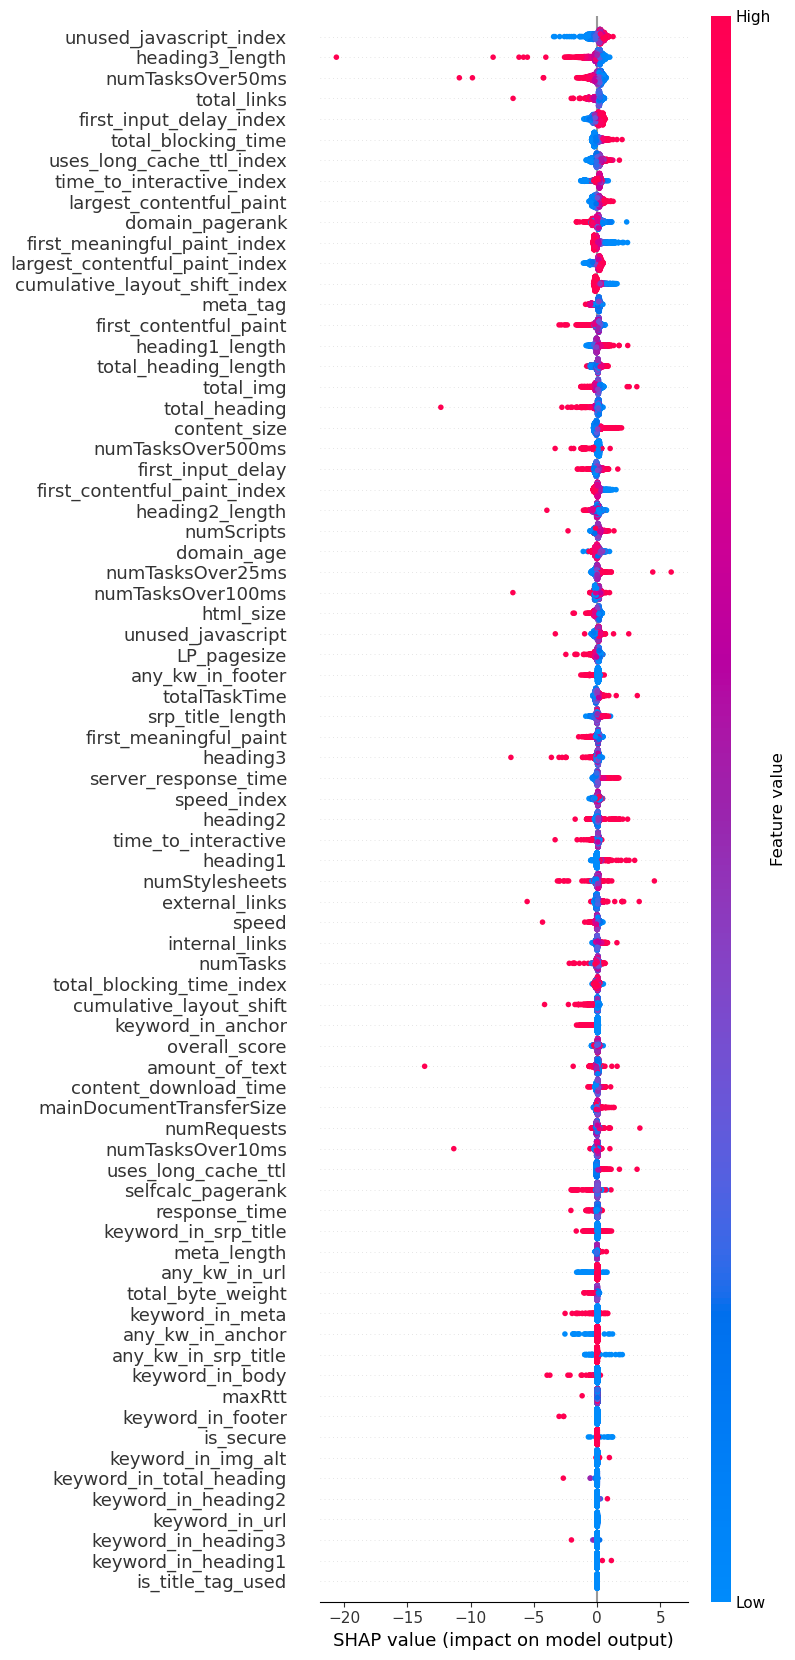

In [93]:
shap.summary_plot(shap_values, features=torch.tensor(test_data.iloc[:, 8:].values, dtype=torch.float32), 
                  feature_names=train_data.columns[8:], plot_size=0.2, max_display=76)

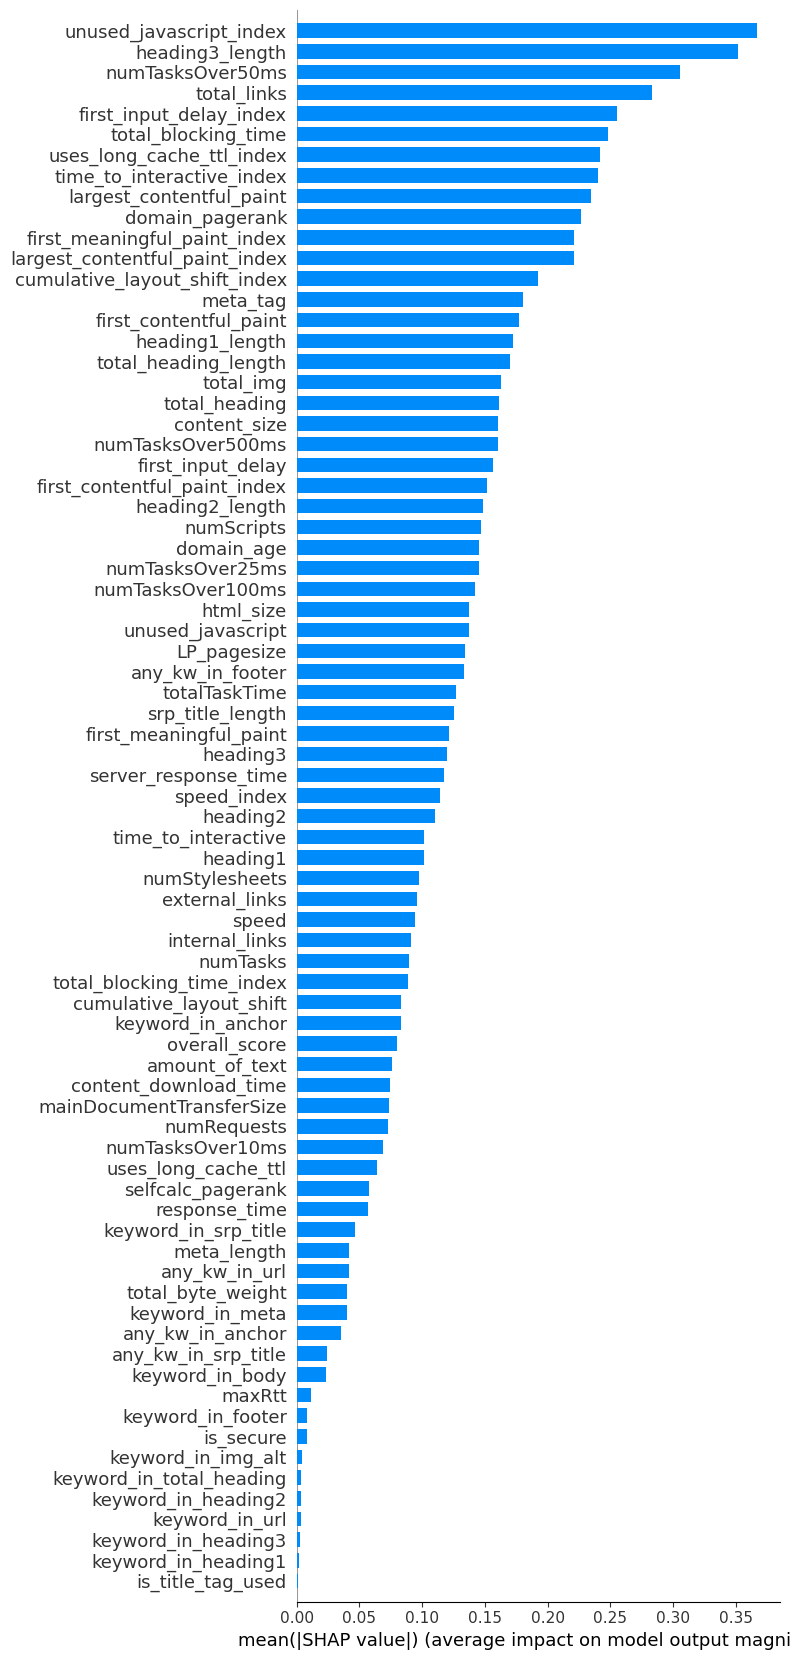

In [91]:
shap.summary_plot(shap_values, features=torch.tensor(test_data.iloc[:, 8:].values, dtype=torch.float32),
                  feature_names=train_data.columns[8:],
                 plot_type='bar', max_display=76, plot_size=0.2)

In [74]:
# Calculate feature importance using gradient
model.eval()
total_grads = 0
# train_dataloader.requires_grad_(True)
for i, v in train_dataloader:
    i.requires_grad_(True)
    outputs = model(i)
    loss = listnet_loss(outputs.view(-1,10), v.float())
    loss.backward()

# Compute feature importance scores
#     grads = i.grad.abs()
    total_grads += i.grad
    
avg_gradients = total_grads / len(train_dataloader.dataset)
grads = avg_gradients.abs()
avg_grads = torch.mean(grads, dim=(0,1), keepdim=True)
feature_importance = (avg_grads / torch.sum(avg_grads)).reshape(76)  # Normalize importance scores

# Sort features based on importance scores
sorted_indices = torch.argsort(feature_importance, descending=True).reshape(76)

# Print feature importance rankings
for i, idx in enumerate(sorted_indices):
    print('Feature', idx.item(), ": Importance Score", feature_importance[idx].item())

Feature 47 : Importance Score 0.03761501610279083
Feature 62 : Importance Score 0.03535402938723564
Feature 22 : Importance Score 0.03492517024278641
Feature 21 : Importance Score 0.032982658594846725
Feature 33 : Importance Score 0.032823532819747925
Feature 17 : Importance Score 0.031211724504828453
Feature 7 : Importance Score 0.0301668718457222
Feature 16 : Importance Score 0.027610844001173973
Feature 48 : Importance Score 0.025828998535871506
Feature 24 : Importance Score 0.025392845273017883
Feature 32 : Importance Score 0.025052279233932495
Feature 69 : Importance Score 0.024172896519303322
Feature 12 : Importance Score 0.02320266328752041
Feature 2 : Importance Score 0.022288454696536064
Feature 5 : Importance Score 0.02194173075258732
Feature 1 : Importance Score 0.019540099427103996
Feature 42 : Importance Score 0.018432725220918655
Feature 28 : Importance Score 0.01820972189307213
Feature 34 : Importance Score 0.01773078367114067
Feature 57 : Importance Score 0.017344290390

In [88]:
name = []
fi = []
for i, idx in enumerate(sorted_indices):
    name.append(train_data.columns[8:][idx.item()])
    fi.append(feature_importance[idx].item())
    print(train_data.columns[8:][idx.item()], ": ", feature_importance[idx].item())

uses_long_cache_ttl :  0.03761501610279083
total_img :  0.03535402938723564
cumulative_layout_shift_index :  0.03492517024278641
first_input_delay_index :  0.032982658594846725
total_blocking_time :  0.032823532819747925
first_contentful_paint_index :  0.031211724504828453
external_links :  0.0301668718457222
first_meaningful_paint_index :  0.027610844001173973
unused_javascript :  0.025828998535871506
unused_javascript_index :  0.025392845273017883
first_contentful_paint :  0.025052279233932495
any_kw_in_url :  0.024172896519303322
content_size :  0.02320266328752041
any_kw_in_srp_title :  0.022288454696536064
total_links :  0.02194173075258732
keyword_in_srp_title :  0.019540099427103996
numTasksOver50ms :  0.018432725220918655
largest_contentful_paint :  0.01820972189307213
server_response_time :  0.01773078367114067
heading2_length :  0.017344290390610695
uses_long_cache_ttl_index :  0.01715783029794693
is_secure :  0.01590588502585888
numScripts :  0.015619956888258457
numTasksOve

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


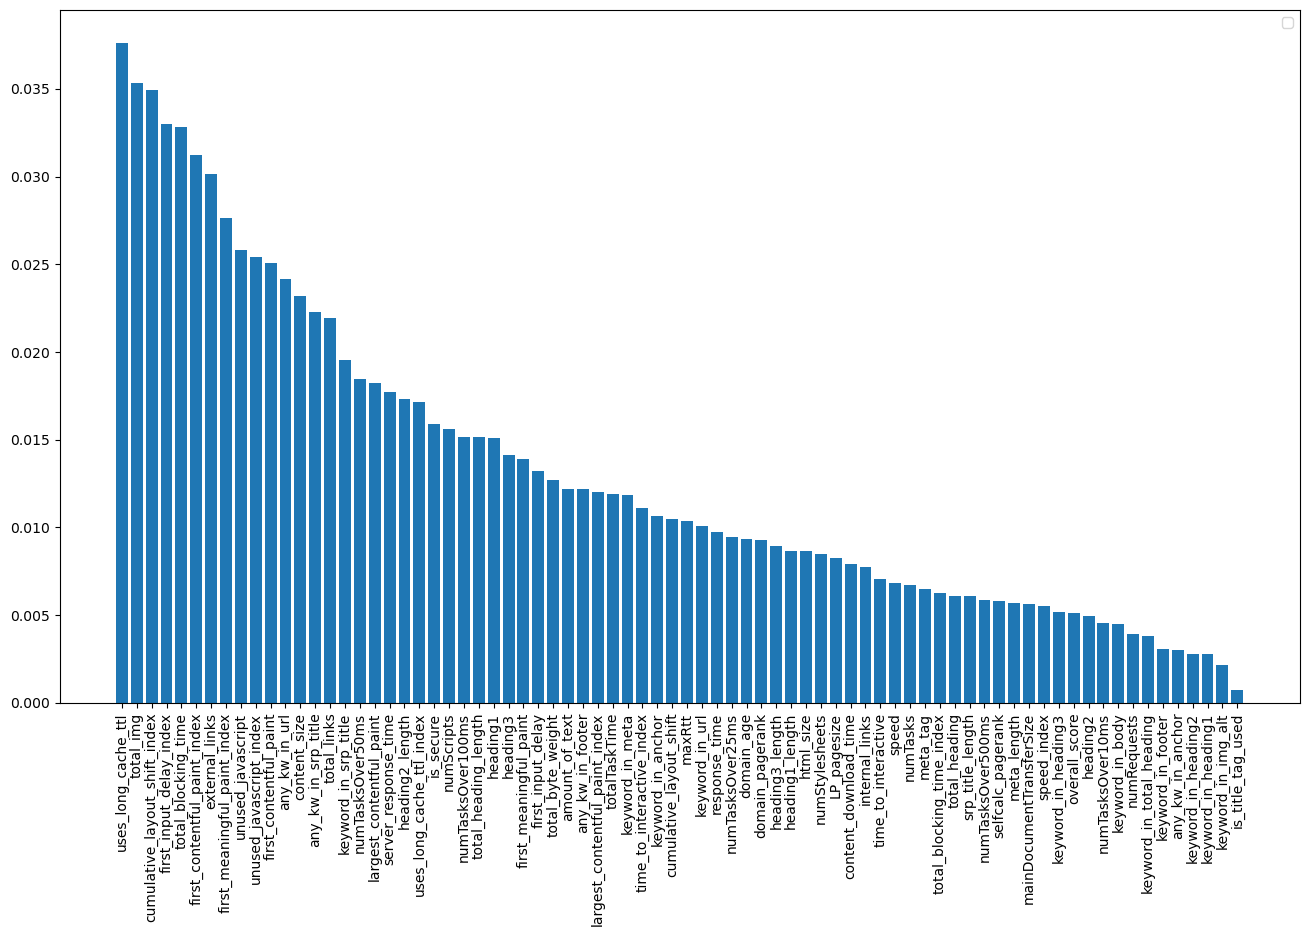

In [92]:
# Visualize feature importance (gradient-based contribution to the model output)
plt.figure(figsize=(16,9))
plt.bar(name, fi)
plt.xticks(rotation=90)
plt.legend()

Visualize performances of different models

([<matplotlib.axis.XTick at 0x20da42b4a30>,
 [Text(1, 0, 'Pointwise'),
  Text(2, 0, 'RankNet'),
  Text(3, 0, 'LambdaRank'),
  Text(4, 0, 'LambdaMART'),
  Text(5, 0, 'ListNet')])

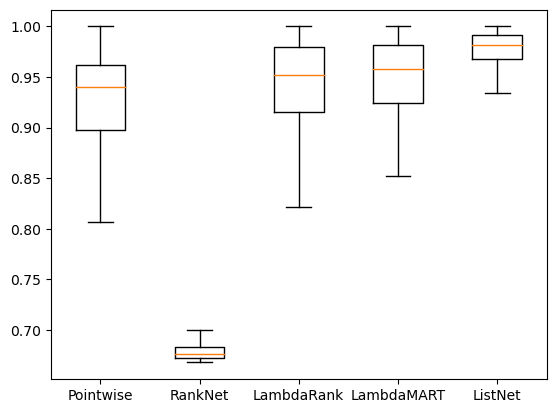

In [47]:
plt.boxplot([scores1, score2, scores3, scores7, scores5], showfliers=False)
plt.xticks([1,2,3,4,5],['Pointwise', 'RankNet', 'LambdaRank', 'LambdaMART', 'ListNet'])